<a href="https://colab.research.google.com/github/RichardHarwood/root_hairs_rhizosphere_soil/blob/main/pore_network_anlaysis_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is just limited, full code is in github.

In [1]:
%%capture
!pip install wget
!pip install porespy
!pip install  imagecodecs

In [2]:
# import wget
# wget.download("https://zenodo.org/records/15009078/files/"+"recon_046_W16_S5.tifroot_prediction2.labels.tif"+"?download=1", out='recon_046_W16_S5.tifroot_prediction2.labels.tif')
# wget.download("https://zenodo.org/records/15009544/files/"+"recon_046_W16_S5_for_colab_eg.tif.tif"+"?download=1", out='recon_046_W16_S5_for_colab_eg.tif.tif')

In [3]:
import skimage
import imagecodecs
roots=skimage.io.imread("/content/recon_046_W16_S5.tifroot_prediction2.labels.tif")
ct=skimage.io.imread("/content/recon_046_W16_S5_for_colab_eg.tif.tif")

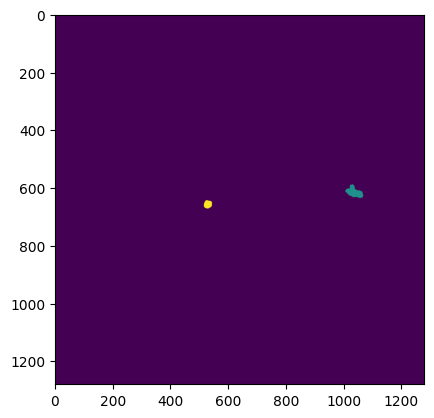

In [4]:
import matplotlib.pyplot as plt
plt.imshow(roots[50])

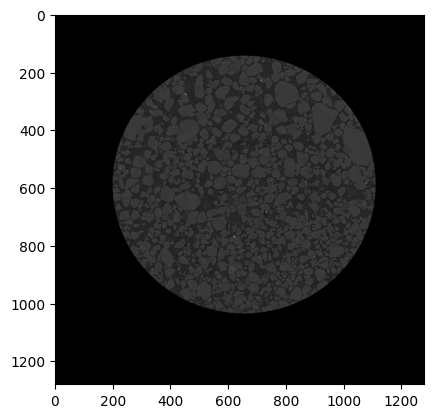

In [5]:
plt.imshow(ct[50], cmap="gray")

Initial number of peaks:  4769
Peaks after trimming saddle points:  3261
Peaks after trimming nearby peaks:  3030


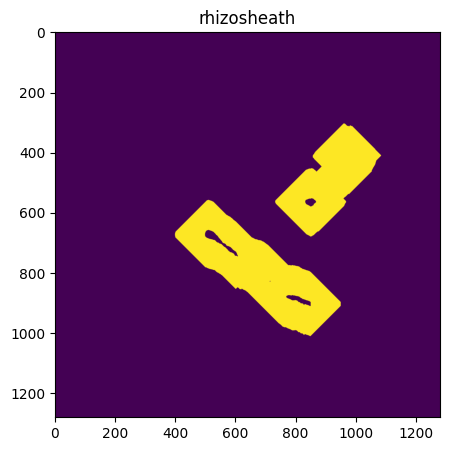

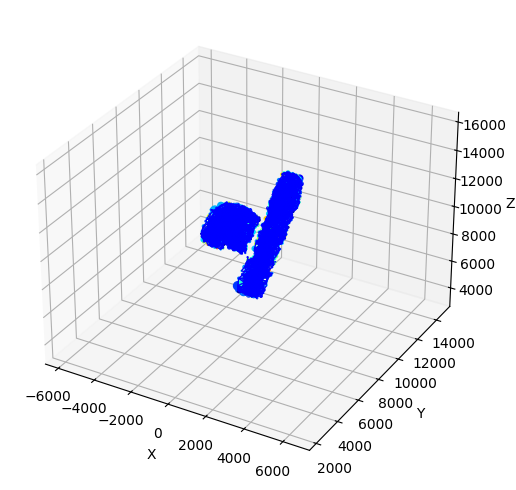

In [8]:

import porespy as ps
import openpnm as op
import scipy.ndimage as spim
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import seaborn as sns
from skimage.filters import threshold_otsu, threshold_yen,threshold_li
#Crop to save ram
root_binary_clean = (roots != 0).astype(bool)[200:250]
ct_data=ct[200:250]

#Dilate around the root to make a rhizosheath
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
iternation_n=100
dilated = ndi.binary_dilation(root_binary_clean, diamond, iterations=iternation_n)
rhizosheath= root_binary_clean ^ dilated
#Get Pore Network
#ct_data=zoom(img, (scale_factor,scale_factor, scale_factor), order=1)
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

thresh_crop=crop_center(ct_data[25],25,25)
thresh = threshold_li(thresh_crop)
pore= ct_data < thresh
#Get Pore Network in Rhizosheath
pore_rhizo=pore * rhizosheath

#######################################
sigma = 0.4
dt = spim.distance_transform_edt(input=pore_rhizo)
dt1 = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)
print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt1)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)
regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)
############################
mat_slice=int(len(rhizosheath)/2)
plt.figure(figsize= (5,5));
plt.imshow(rhizosheath[mat_slice]);
plt.title("rhizosheath");
plt.show();

import pandas as pd
import imageio
net = ps.networks.regions_to_network(regions*pore_rhizo, voxel_size=13)
pn = op.io.network_from_porespy(net)

pore_region_volume_df=pd.DataFrame(pn['pore.region_volume'])
throat_cons_df=pd.DataFrame(pn['throat.conns'])

#saves data for visualising, cant be donw in colab, check our parraview
#pore_rhizo = (np.swapaxes(pore_rhizo, 2, 0)) # This isjust some of ps.tools.align_image_with_openpnm(im), it works to align image with
#imageio.volsave(file_paths_processed+'pore_networkfor_rhizosheath.tif', np.array(pore_rhizo, dtype=np.int8))
#op.io.project_to_vtk(project=pn.project,filename=(file_paths_processed+"pore_network"))

#sns.kdeplot(data=pore_region_volume_df, x=0).set_title("Spead of region pore size");

fig, ax = plt.subplots(figsize=[5, 5])
#ax.imshow(slice_2d.T, cmap=plt.cm.bone);
op.visualization.plot_coordinates(ax=fig,
                                  network=pn,
                                  size_by=pn["pore.region_volume"],
                                  color_by=pn["throat.total_length"],
                                  markersize=50)
op.visualization.plot_connections(network=pn, ax=fig)
ax.set_title('Pore Network in the rhizosheath')
plt.show()




In [9]:
# #interact with the pore network
# op.visualization.plot_notebook(network=pn, node_color=0, edge_color=0, node_size=1, node_scale=20, edge_scale=5, colormap='viridis')
